## Getting Started

In [1]:
from COMPOSITION import *

/home/jeongbinpark/miniconda3/envs/minibatch/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/jeongbinpark/miniconda3/envs/minibatch/lib/python3.10/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/home/jeongbinpark/miniconda3/envs/minibatch/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warning

In [2]:
"""
We prepared AnnData as follows

# raw counts
counts = pd.read_csv('mouse_hypothalamic/counts_-0.14.tsv', sep='\t', header=0, index_col=0)
counts = counts.T
counts = counts.drop(columns=counts.columns[ counts.isnull().sum(axis=0) > 0 ])
adata = anndata.AnnData(counts)

# annotation: should contain 'x' and 'y'
df = pd.read_csv('mouse_hypothalamic/annotation.tsv', sep='\t', header=0, index_col=0)
df = df[df.bregma == -0.14]
adata.obs = adata.obs.join(df)

adata.write_h5ad("mouse_hypothalamus.h5ad")
"""

adata = sc.read_h5ad("mouse_hypothalamus.h5ad")
print(adata)

AnnData object with n_obs × n_vars = 5926 × 155
    obs: 'x', 'y', 'Cell_class', 'Neuron_cluster_ID', 'z', 'bregma'


## Running

Found existing 'x', 'y' in adata.obs. Nothing to do.


/home/jeongbinpark/miniconda3/envs/minibatch/lib/python3.10/site-packages/torch_geometric/loader/neighbor_loader.py:229: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  neighbor_sampler = NeighborSampler(
/home/jeongbinpark/_Spatial_VGAE/COMPOSITION.py:416: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  p = F.softmax(z)                                                # mixture probability


Epoch 0 Loss: 208979.53125
Epoch 50 Loss: 145493.53125
Epoch 100 Loss: 125955.328125
Epoch 150 Loss: 114615.28125
Epoch 200 Loss: 106985.2890625
Epoch 250 Loss: 102882.1953125
Epoch 300 Loss: 100394.109375
Epoch 350 Loss: 99114.0
Epoch 400 Loss: 98104.5625
Epoch 450 Loss: 97503.9765625
Epoch 500 Loss: 110139.4140625
Epoch 550 Loss: 107107.96875
Epoch 600 Loss: 107215.5546875
Epoch 650 Loss: 106356.7421875
Epoch 700 Loss: 106330.5234375
Epoch 750 Loss: 106027.2890625
Epoch 800 Loss: 106350.6484375
Epoch 850 Loss: 105885.6875
Epoch 900 Loss: 106139.5625
Epoch 950 Loss: 106034.9609375
Epoch 1000 Loss: 111370.6015625
Epoch 1050 Loss: 109305.3359375
Epoch 1100 Loss: 109108.015625
Epoch 1150 Loss: 108980.9453125
Epoch 1200 Loss: 108851.1015625
Epoch 1250 Loss: 108696.109375
Epoch 1300 Loss: 109047.578125
Epoch 1350 Loss: 109239.09375
Epoch 1400 Loss: 109283.109375
Epoch 1450 Loss: 108825.2109375
Epoch 1500 Loss: 109890.828125
Epoch 1550 Loss: 108273.5546875
Epoch 1600 Loss: 109723.171875
Epo

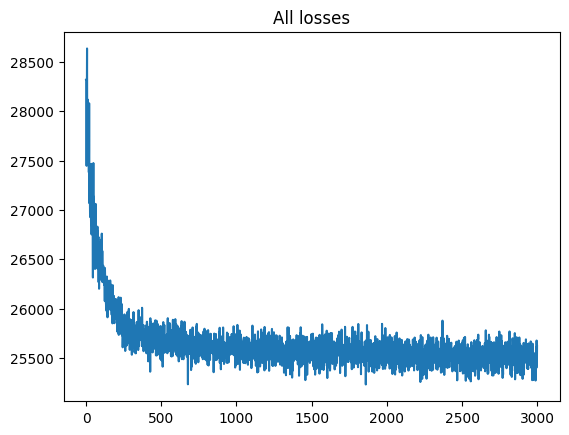

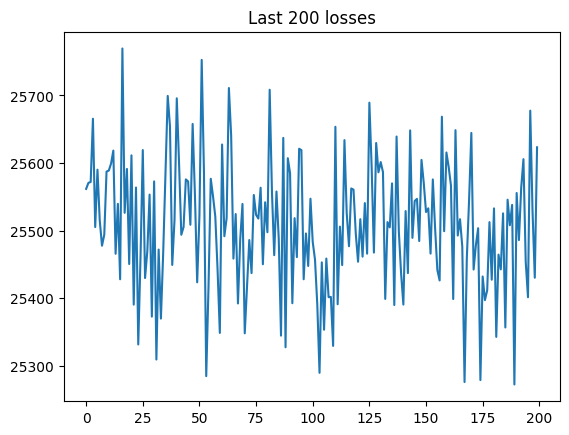

/home/jeongbinpark/_Spatial_VGAE/COMPOSITION.py:133: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  recon = F.softmax(model_ff(p))             # reconstructed distribution over vocabulary


In [3]:
data, dataloader = step1_preprocess(adata)
model, model_ct, model_ff = step2_run(data, dataloader, num_topics=16, tanh_thr=0.005)
    # For more fine-grained domains (e.g., brain cortex), num_topics and tanh_thr should be low
p, cell_types_niche, cell_types_vae, niche_composition, pred_domains, recon_celltype, logits = \
    step3_postprocess(data, model, model_ct, model_ff)

## Visualization

### Niche density

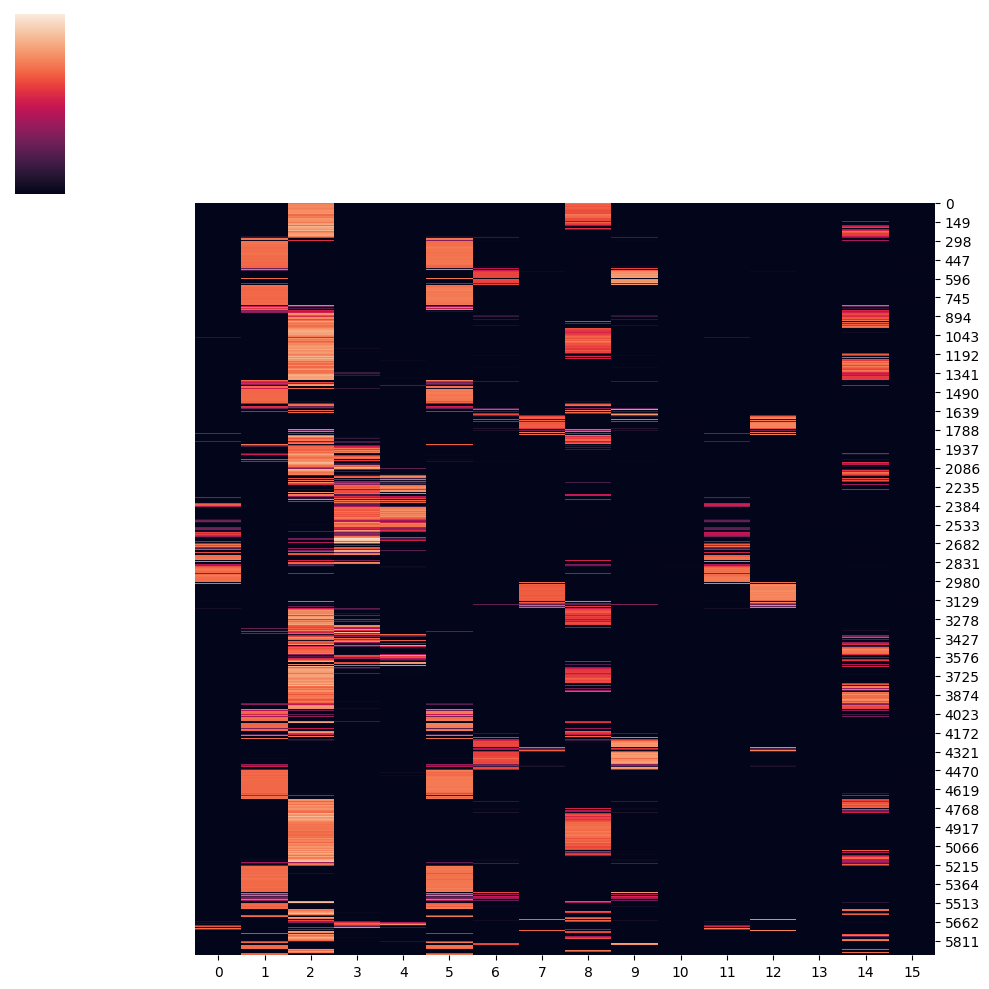

In [4]:
seaborn.clustermap( p.detach().cpu().numpy(), row_cluster=False, col_cluster=False)
plt.axis(False)
plt.show()

### cell_types_niche (continuous)

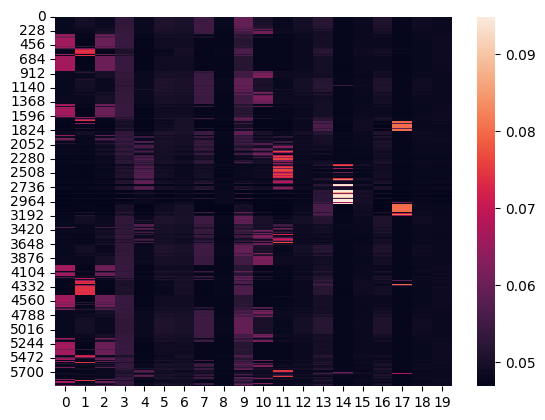

In [5]:
seaborn.heatmap(F.softmax(model_ff(p), dim=1).detach().cpu())
plt.show()

### cell_types_vae (continuous)

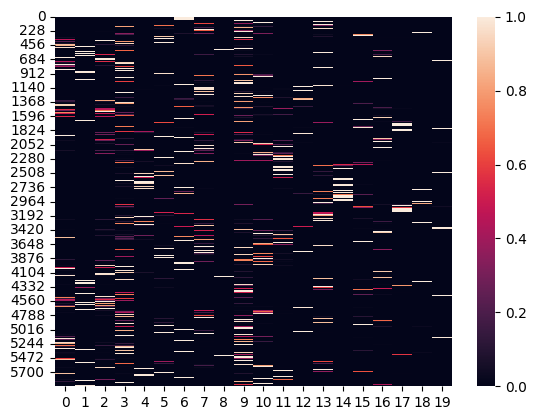

In [6]:
seaborn.heatmap(F.softmax(logits, dim=1).detach().cpu())
plt.show()

### niche_composition (cell type proportions per topic)

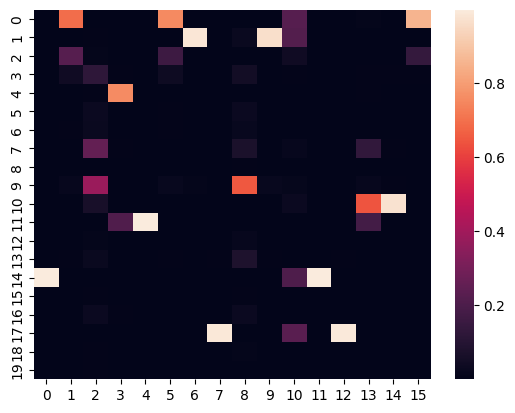

In [7]:
seaborn.heatmap( niche_composition.numpy() )
plt.show()

### domain

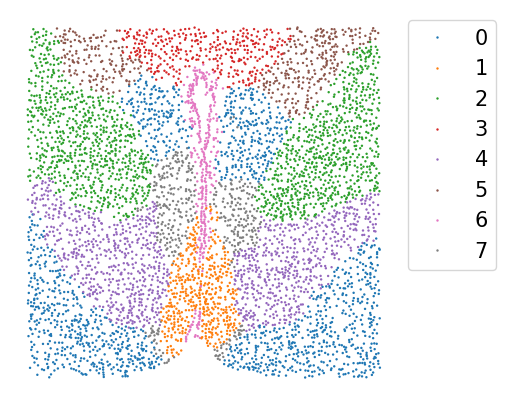

In [8]:
plt.rc('font', size=15)
plt.figure(figsize=(5, 5))
spatial_coords = adata.obs[['x', 'y']]
seaborn.scatterplot(x=spatial_coords.x, y=spatial_coords.y, hue=pred_domains, palette='tab10', s=3, linewidth=0)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.axis('off')
plt.show()